# MLP para regressão no contexto de ressonância magnética

## Bibliotecas

In [1]:
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

## Ingestão dos Dados

In [2]:
# Carregar os dados de treinamento
df = pd.read_csv('../data/ressonanciaMLP.csv')
df.head()

,x1,x2,x3,d
0,0.8799,0.7998,0.3972,0.8399
1,0.5700,0.5111,0.2418,0.6258
2,0.6796,0.4117,0.3370,0.6622
3,0.3567,0.2967,0.6037,0.5969
4,0.3866,0.8390,0.0232,0.5316


In [3]:
# Carregar os dados de teste
df_test = pd.read_csv('../data/ressonanciaMLPTest.csv')

In [4]:
# Verificar dtypes e demais informações do df_test
df_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      20 non-null     float64
 1   x2      20 non-null     float64
 2   x3      20 non-null     float64
 3   d       20 non-null     float64
dtypes: float64(4)
memory usage: 768.0 bytes


# Treinamento

In [5]:
# Separando o database em treino e teste
X_train, X_test = df.iloc[:, :3], df_test.iloc[:, :3]
y_train, y_test = df.iloc[:, 3], df_test.iloc[:, 3]

In [6]:
# Declara o regressor MLP
model = MLPRegressor(learning_rate='constant', learning_rate_init=.01,
                     max_iter=1000)
param_grid = {
    'hidden_layer_sizes': [5, 10, 15],
    'activation': ['relu', 'logistic', 'tanh']
}

In [7]:
# Buscar a melhor rede neural para o problema de regressão
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=MLPRegressor(learning_rate_init=0.01, max_iter=1000),
             param_grid={'activation': ['relu', 'logistic', 'tanh'],
                         'hidden_layer_sizes': [5, 10, 15]},
             scoring='neg_mean_squared_error')

In [8]:
# Resultados do GridSearchCV
results = grid_search.cv_results_

# Criar dataframe com os resultados
trained_models = []  # lista vazia para ser preenchida com os modelos treinados

for i, params in enumerate(results['params']):
    model = grid_search.best_estimator_.set_params(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    loss_final = mean_squared_error(y_test, y_pred)
    trained_models.append({
        'Treinamento': f'T{i + 1}',
        'Neurônios': params['hidden_layer_sizes'],
        'Ativação': params['activation'],
        'Perda Final': -results['mean_test_score'][i],
        'Número de épocas': model.n_iter_
    })

df_results = pd.DataFrame(trained_models)
df_results['Ranking da Melhor Configuração'] = (
    df_results['Perda Final']
    .rank(method='min')
    .astype('int64')
)


In [9]:
# Mostra a tabela de resultados
df_results

,Treinamento,Neurônios,Ativação,Perda Final,Número de épocas,Ranking da Melhor Configuração
0,T1,5,relu,0.044533,31,8
1,T2,10,relu,0.015160,54,1
2,T3,15,relu,0.028571,36,4
3,T4,5,logistic,0.025371,44,3
4,T5,10,logistic,0.033260,99,5
5,T6,15,logistic,0.021248,19,2
6,T7,5,tanh,0.049546,90,9
7,T8,10,tanh,0.034289,99,6
8,T9,15,tanh,0.039002,59,7


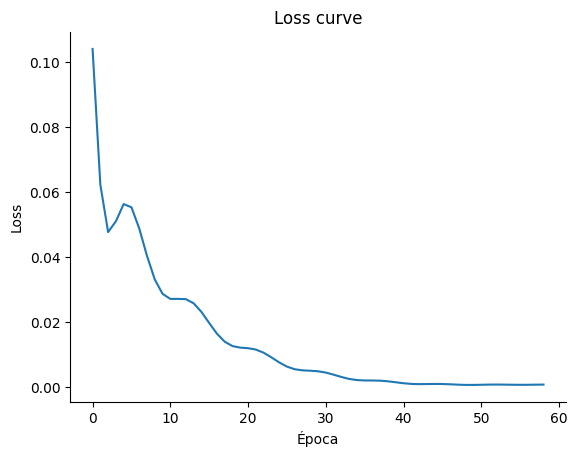

In [10]:
# Gráfico de perda (loss) da melhor configuração 
plt.plot(grid_search.best_estimator_.loss_curve_)
plt.title('Loss curve')
plt.xlabel('Época')
plt.ylabel('Loss')
sns.despine();

In [11]:
# Validação da melhor configuração
print(f'Mean Absolut Error (MAE): {mean_absolute_error(y_test,grid_search.best_estimator_.predict(X_test))}')
print(f'Mean Squared Error (MSE): {mean_squared_error(y_test,grid_search.best_estimator_.predict(X_test))}')
print(f'Root Mean Squared Error (RMSE): {root_mean_squared_error(y_test,grid_search.best_estimator_.predict(X_test))}')
print(f'Mean Anbsolute ercentage Error (MAPE): {mean_absolute_percentage_error(y_test,grid_search.best_estimator_.predict(X_test))}')

Mean Absolut Error (MAE): 0.02912634009690641
Mean Squared Error (MSE): 0.0011608381995183137
Root Mean Squared Error (RMSE): 0.034071075702394746
Mean Anbsolute ercentage Error (MAPE): 0.052328147631629504


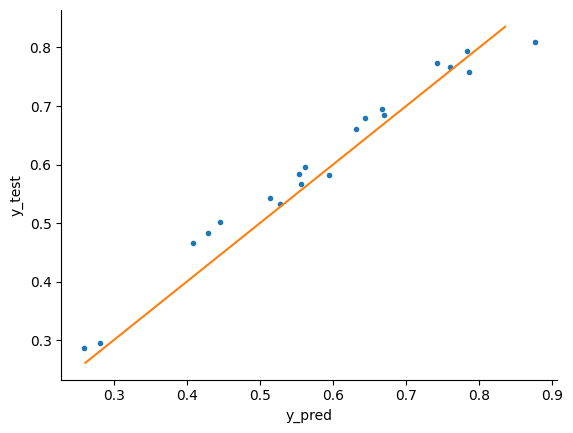

In [12]:
# Plot dos valores verdadeiros contra as predições
y_pred = grid_search.best_estimator_.predict(X_test)
plt.plot(y_pred, y_test, '.')
plt.plot(plt.gca().get_ylim(), plt.gca().get_ylim())
plt.xlabel('y_pred')
plt.ylabel('y_test')
sns.despine();